# Overlay Analysis: Identifying Key Corridors from Circuitscape Results

Now that we have the Circuitscape results, we will extract and analyze potential movement corridors. This step is critical for understanding connectivity patterns and follows the final analysis phase outlined in Donati et al. (2022).

##  1. Rationale for Corridor Identification

### Why Identify Corridors?
1. High current flow areas represent strong movement potential (McRae et al., 2008).
2. Identifying key corridors can inform conservation actions by showing where connectivity is highest (Keeley et al., 2016).
3. Blue-Green Infrastructure (BGI) planning requires knowing where amphibians are likely to move, so interventions can be targeted effectively (Donati et al., 2022).

### How Do We Define Corridors?
We will test two different approaches:

1. Thresholding High-Current Areas → Extracting the top 10% (90th percentile) of connectivity values.
2. Clustering Connectivity Hotspots → Grouping high-movement zones using spatial clustering algorithms (e.g., DBSCAN or k-means).

## 2. Extracting Corridors Using Thresholding

This method selects the top 10% of current flow values to define high-movement pathways.

## **(First Test on Preliminary Results)**

### Masking Focal Nodes

In [11]:
# Define the focal nodes raster path
focal_nodes_path = r"C:/GIS_Course/MScThesis-MaviSantarelli/data/Clipped/Focal_Nodes_Clipped.asc"

# Load the focal nodes raster
with rasterio.open(focal_nodes_path) as src:
    focal_nodes_data = src.read(1)  # Read focal node values
    focal_nodes_mask = focal_nodes_data > 0  # Mask where focal nodes exist


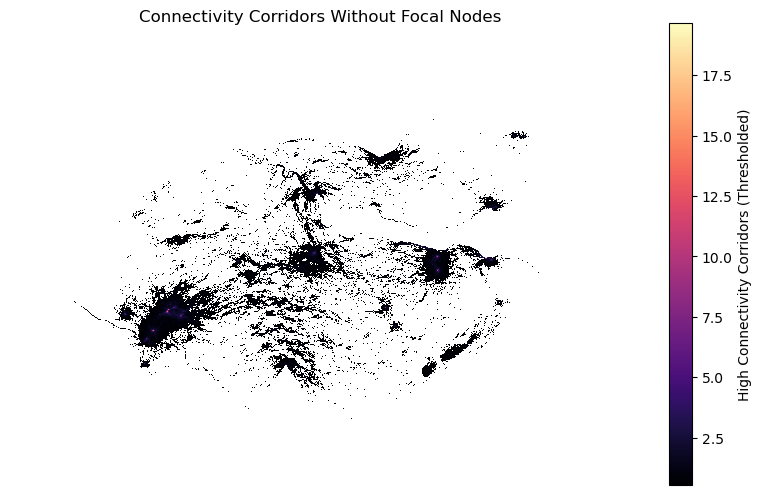

In [12]:
# Apply the mask: Set focal nodes to NaN
corridors_no_focal_nodes = np.where(focal_nodes_mask, np.nan, corridors)

# Plot the corridors without focal nodes
plt.figure(figsize=(10, 6))
plt.imshow(corridors_no_focal_nodes, cmap="magma", interpolation="none")
plt.colorbar(label="High Connectivity Corridors (Thresholded)")
plt.title("Connectivity Corridors Without Focal Nodes")
plt.axis("off")
plt.show()


In [13]:
# Define output path
output_corridor_path = r"C:/GIS_Course/MScThesis-MaviSantarelli/results/Connectivity/Inv_Bufo_Clipped_Results_NoFocalNodes.asc"

# Save updated raster
with rasterio.open(result_path) as src:
    meta = src.meta.copy()
    meta.update(dtype=rasterio.float32, nodata=-9999)

    with rasterio.open(output_corridor_path, "w", **meta) as dst:
        dst.write(corridors_no_focal_nodes.astype(np.float32), 1)

print(f"✅ Updated corridor raster saved at: {output_corridor_path}")


✅ Updated corridor raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Connectivity/Inv_Bufo_Clipped_Results_NoFocalNodes.asc


### Refine the Corridor Identification

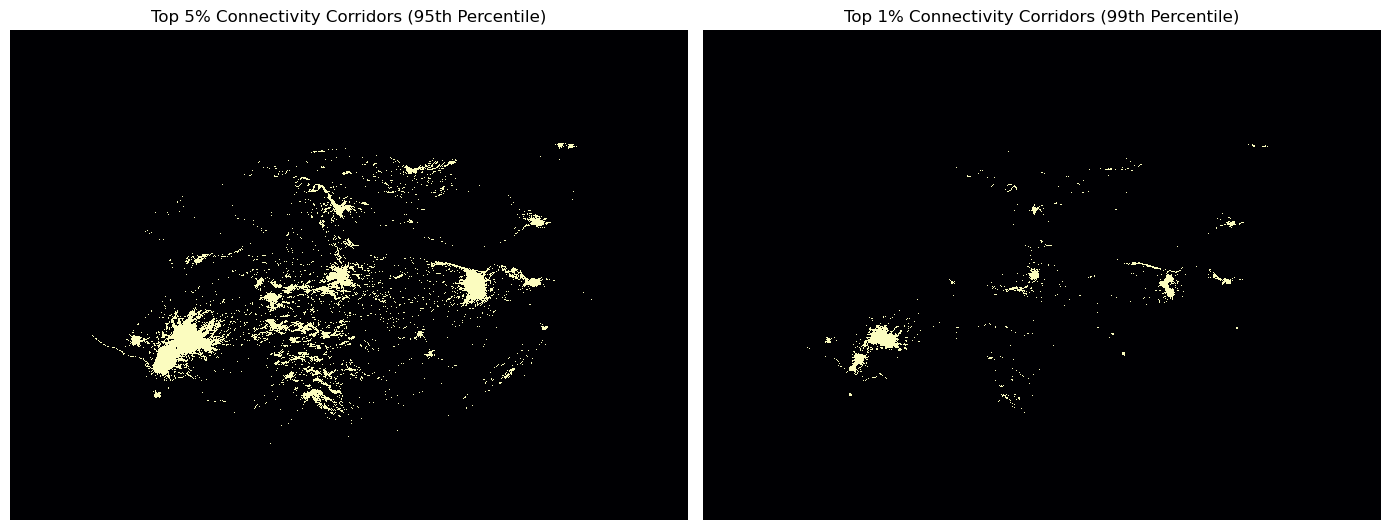

In [14]:
# Test multiple thresholds
threshold_95 = np.nanpercentile(data, 95)
threshold_99 = np.nanpercentile(data, 99)

# Generate binary corridor maps
corridors_95 = np.where(data >= threshold_95, 1, 0)
corridors_99 = np.where(data >= threshold_99, 1, 0)

# Plot comparison of different thresholds
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(corridors_95, cmap="magma", interpolation="none")
axes[0].set_title("Top 5% Connectivity Corridors (95th Percentile)")
axes[0].axis("off")

axes[1].imshow(corridors_99, cmap="magma", interpolation="none")
axes[1].set_title("Top 1% Connectivity Corridors (99th Percentile)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


### Overlay with Urban Green & Grey Spaces

In [20]:
import osmnx as ox
import geopandas as gpd

# Define paths
study_area_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/StudyArea/Buffer.shp"
output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/data/Urban"

# Load study area and reproject to WGS 84 (EPSG:4326)
study_area = gpd.read_file(study_area_path)
study_area = study_area.to_crs(epsg=4326)  # Convert from BNG (EPSG:27700) to WGS 84 (EPSG:4326)

# Get bounding box for OSM query
minx, miny, maxx, maxy = study_area.total_bounds

# Define OSM tags for urban features
tags = {
    "greenspaces": {"leisure": ["park", "garden", "nature_reserve"]},
    "roads": {"highway": True},
    "buildings": {"building": True},
}

# Extract OSM data for each category
for name, tag in tags.items():
    print(f"🔍 Extracting {name} from OSM...")

    # Corrected function call: Pass only bbox and tag dictionary
    gdf = ox.features_from_bbox(bbox=(maxy, miny, maxx, minx), tags=tag)

    # Convert OSM data to British National Grid (EPSG:27700)
    gdf = gdf.to_crs(epsg=27700)

    # Clip OSM data to the study area
    gdf = gpd.overlay(gdf, study_area, how="intersection")

    # Save as shapefile
    output_path = f"{output_dir}/OSM_{name}.shp"
    gdf.to_file(output_path)
    print(f"✅ {name.capitalize()} saved at: {output_path}")

print("🎯 OSM extraction complete!")


🔍 Extracting greenspaces from OSM...


C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\osmnx\_overpass.py:267: UserWarning: This area is 15,078 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


KeyboardInterrupt: 